In [35]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import OneClassSVM

In [16]:
df = pd.read_csv('./data/spambase.data', header=None)
display(df.head())

data, labels = df.iloc[:, :57].values, df.iloc[:, 57].values
print(data.shape, np.count_nonzero(labels))
#print(df.isnull().sum())

0     1     2    3     4     5     6     7     8     9   ...    48  \
0  0.00  0.64  0.64  0.0  0.32  0.00  0.00  0.00  0.00  0.00  ...  0.00   
1  0.21  0.28  0.50  0.0  0.14  0.28  0.21  0.07  0.00  0.94  ...  0.00   
2  0.06  0.00  0.71  0.0  1.23  0.19  0.19  0.12  0.64  0.25  ...  0.01   
3  0.00  0.00  0.00  0.0  0.63  0.00  0.31  0.63  0.31  0.63  ...  0.00   
4  0.00  0.00  0.00  0.0  0.63  0.00  0.31  0.63  0.31  0.63  ...  0.00   

      49   50     51     52     53     54   55    56  57  
0  0.000  0.0  0.778  0.000  0.000  3.756   61   278   1  
1  0.132  0.0  0.372  0.180  0.048  5.114  101  1028   1  
2  0.143  0.0  0.276  0.184  0.010  9.821  485  2259   1  
3  0.137  0.0  0.137  0.000  0.000  3.537   40   191   1  
4  0.135  0.0  0.135  0.000  0.000  3.537   40   191   1  

[5 rows x 58 columns]

(4601, 57) 1813
[1 1 1 ... 0 0 0]


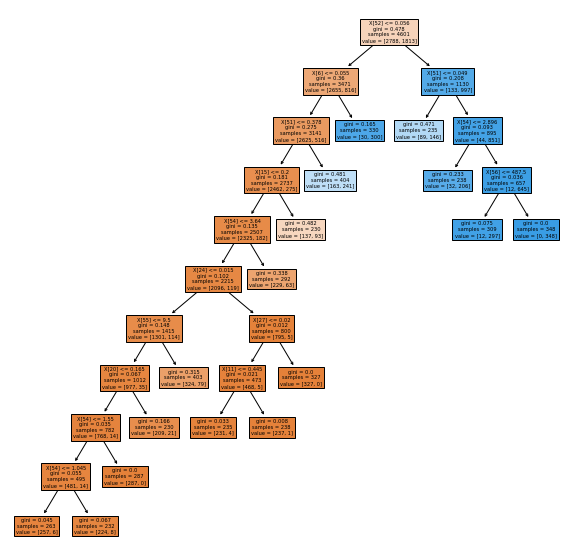

In [57]:
# Build and visualize classification tree

min_split = int(data.shape[0]*.05)
#print(min_split)

tree_model_default = DecisionTreeClassifier().fit(data, labels)
tree_model = DecisionTreeClassifier(min_samples_leaf=min_split).fit(data, labels)

print(tree_model.get_depth(), tree_model.get_n_leaves())

plt.figure(figsize=(10, 10))
plot_tree(tree_model, filled=True)
plt.show()

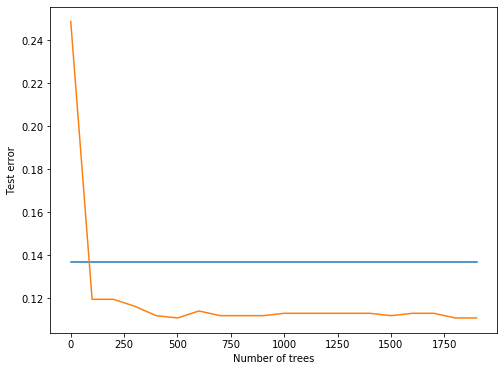

In [70]:
# decision tree and random forest comparison 

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)

# overwrite old tree model
tree_model = DecisionTreeClassifier(min_samples_leaf=min_split, random_state=0).fit(X_train, y_train)

tree_test_err = []
forest_test_err = []

for n in range(1, 2000, 100):
    
    tree_pred = tree_model.predict(X_test)
    random_forest = RandomForestClassifier(n_estimators=n, max_depth=2, random_state=0).fit(X_train, y_train)
    forest_pred = random_forest.predict(X_test)
    
    tree_test_err.append(1 - accuracy_score(y_test, tree_pred))
    forest_test_err.append(1 - accuracy_score(y_test, forest_pred))
    

plt.figure(figsize=(8, 6))
plt.plot(list(range(1, 2000, 100)), tree_test_err)
plt.plot(list(range(1, 2000, 100)), forest_test_err)
plt.xlabel("Number of trees")
plt.ylabel("Test error")
plt.show()

In [74]:
print(tree_test_err[0])
print(min(forest_test_err))
print(forest_test_err.index(min(forest_test_err)))
print(list(range(1, 5000, 100))[forest_test_err.index(min(forest_test_err))])

0.1368078175895765
0.11074918566775249
5
501


In [34]:
# one-class kernel SVM

# can reuse previous data splitting because it has been split and shuffled
X_train_new = []
y_train_new = []
for pt in zip(X_train, y_train):
    if pt[1] == 0:
        X_train_new.append(pt[0])
        y_train_new.append(pt[1])
        
X_train_new = np.asarray(X_train_new)
y_train_new = np.asarray(y_train_new)
print(X_train_new.shape)

(2239, 57)


[1 0 1 1 0 1 0 1 1 1 0 1 1 1 1 1 0 1 1 0]
[0 0 1 1 0 1 0 1 0 1 0 1 0 1 1 1 0 0 0 0]


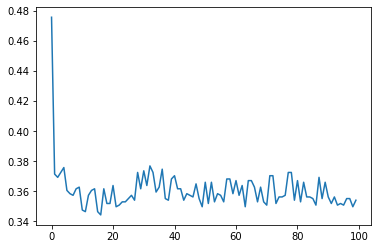

In [55]:
# determine best choice for kernel bandwidth

svm_test_err = []
for gamma in np.arange(1e-6, .01, 1e-4):
    
    svm = OneClassSVM(kernel='rbf', gamma=gamma).fit(X_train_new)
    svm_pred = svm.predict(X_test)
    svm_pred = np.where(svm_pred == 1, 0, 1)
    svm_test_err.append(1 - accuracy_score(y_test, svm_pred))

    
print(svm_pred[0:20]) 
print(y_test[0:20])
plt.plot(svm_test_err)

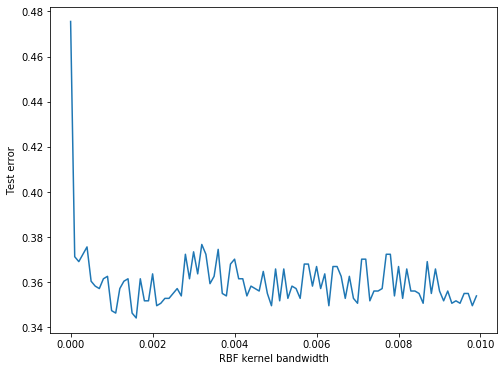

0.3441910966340934
16
0.001601


In [76]:
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1e-6, .01, 1e-4), svm_test_err)

plt.xlabel("RBF kernel bandwidth")
plt.ylabel("Test error")
plt.show()

# finding the optimal kernel bandwidth
print(min(svm_test_err))
print(svm_test_err.index(min(svm_test_err)))
print(np.arange(1e-6, .01, 1e-4)[svm_test_err.index(min(svm_test_err))])